# Object Detection Demo 5: Stream of Images (Screen-capture + Webcam Feed)
Welcome to the object detection inference walkthrough!  This notebook will walk you step by step through the process of using a pre-trained model to detect objects in an image. Make sure to follow the [installation instructions](https://github.com/tensorflow/models/blob/master/object_detection/g3doc/installation.md) before you start.

# Imports

In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
import getpass

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

from PIL import ImageGrab
import time
import pandas as pd

import cv2

## Env setup

In [2]:
# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")

## Object detection imports
Here are the imports from the object detection module.

In [3]:
from utils import label_map_util

from utils import visualization_utils as vis_util

# Model preparation 

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_CKPT` to point to a new .pb file.  

By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

In [4]:
# What model to download.
MODEL_NAME = 'ssd_mobilenet_v1_coco_11_06_2017'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('data', 'mscoco_label_map.pbtxt')

NUM_CLASSES = 90

## Download Model

opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
tar_file = tarfile.open(MODEL_FILE)
for file in tar_file.getmembers():
  file_name = os.path.basename(file.name)
  if 'frozen_inference_graph.pb' in file_name:
    tar_file.extract(file, os.getcwd())

## Load a (frozen) Tensorflow model into memory.

In [5]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [6]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [7]:
category_index

{1: {'id': 1, 'name': 'person'},
 2: {'id': 2, 'name': 'bicycle'},
 3: {'id': 3, 'name': 'car'},
 4: {'id': 4, 'name': 'motorcycle'},
 5: {'id': 5, 'name': 'airplane'},
 6: {'id': 6, 'name': 'bus'},
 7: {'id': 7, 'name': 'train'},
 8: {'id': 8, 'name': 'truck'},
 9: {'id': 9, 'name': 'boat'},
 10: {'id': 10, 'name': 'traffic light'},
 11: {'id': 11, 'name': 'fire hydrant'},
 13: {'id': 13, 'name': 'stop sign'},
 14: {'id': 14, 'name': 'parking meter'},
 15: {'id': 15, 'name': 'bench'},
 16: {'id': 16, 'name': 'bird'},
 17: {'id': 17, 'name': 'cat'},
 18: {'id': 18, 'name': 'dog'},
 19: {'id': 19, 'name': 'horse'},
 20: {'id': 20, 'name': 'sheep'},
 21: {'id': 21, 'name': 'cow'},
 22: {'id': 22, 'name': 'elephant'},
 23: {'id': 23, 'name': 'bear'},
 24: {'id': 24, 'name': 'zebra'},
 25: {'id': 25, 'name': 'giraffe'},
 27: {'id': 27, 'name': 'backpack'},
 28: {'id': 28, 'name': 'umbrella'},
 31: {'id': 31, 'name': 'handbag'},
 32: {'id': 32, 'name': 'tie'},
 33: {'id': 33, 'name': 'suitc

## Helper code

In [8]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

This is a helper function that takes the detection graph output tensor (np arrays), stacks the classes and scores, and determines if the class for a person (1) is available within a certain score and within a certain amount of objects

In [9]:
def object_counter(classes_arr, scores_arr, score_thresh=0.5):
    # Process the numpy array of classes from the model
    stacked_arr = np.stack((classes_arr, scores_arr), axis=-1)
    # Convert to pandas dataframe for easier querying
    detection_df = pd.DataFrame(stacked_arr)
    # Retrieve total count of cars with score threshold above param value
    detected_cars = detection_df[(detection_df[0] == 3.0) & (detection_df[1] > score_thresh)]
    detected_people =  detection_df[(detection_df[0] == 1.0) & (detection_df[1] > score_thresh)]
    detected_bicycles =  detection_df[(detection_df[0] == 2.0) & (detection_df[1] > score_thresh)]
    detected_motorcycles =  detection_df[(detection_df[0] == 4.0) & (detection_df[1] > score_thresh)]
    detected_buses =  detection_df[(detection_df[0] == 6.0) & (detection_df[1] > score_thresh)]
    detected_trucks =  detection_df[(detection_df[0] == 8.0) & (detection_df[1] > score_thresh)]
    
    car_count = len(detected_cars)
    people_count = len(detected_people)
    bicycle_count = len(detected_bicycles)
    motorcycle_count = len(detected_motorcycles)
    bus_count = len(detected_buses)
    truck_count = len(detected_trucks)

    return car_count, people_count, bicycle_count, motorcycle_count, bus_count, truck_count

In [10]:
def car_counter(classes_arr, scores_arr, score_thresh=0.5):
    # Process the numpy array of classes from the model
    stacked_arr = np.stack((classes_arr, scores_arr), axis=-1)
    # Convert to pandas dataframe for easier querying
    detection_df = pd.DataFrame(stacked_arr)
    # Retrieve total count of cars with score threshold above param value
    detected_cars = detection_df[(detection_df[0] == 3.0) & (detection_df[1] > score_thresh)]
    car_count = len(detected_cars)
    
    return car_count

In [11]:
def person_in_image(classes_arr, scores_arr, obj_thresh=5, score_thresh=0.5):
    stacked_arr = np.stack((classes_arr, scores_arr), axis=-1)
    person_found_flag = False
    for ix in range(obj_thresh):
        if 1.00000000e+00 in stacked_arr[ix]:
            if stacked_arr[ix][1] >= score_thresh:
                person_found_flag = True
            
    return person_found_flag

### Labeled Classes

{1: {'id': 1, 'name': 'person'},
 2: {'id': 2, 'name': 'bicycle'},
 3: {'id': 3, 'name': 'car'},
 4: {'id': 4, 'name': 'motorcycle'},
 5: {'id': 5, 'name': 'airplane'},
 6: {'id': 6, 'name': 'bus'},
 7: {'id': 7, 'name': 'train'},
 8: {'id': 8, 'name': 'truck'},
 9: {'id': 9, 'name': 'boat'},
 10: {'id': 10, 'name': 'traffic light'},
 11: {'id': 11, 'name': 'fire hydrant'},
 13: {'id': 13, 'name': 'stop sign'},
 14: {'id': 14, 'name': 'parking meter'},
 15: {'id': 15, 'name': 'bench'},
 16: {'id': 16, 'name': 'bird'},
 17: {'id': 17, 'name': 'cat'},
 18: {'id': 18, 'name': 'dog'},
 19: {'id': 19, 'name': 'horse'},
 20: {'id': 20, 'name': 'sheep'},
 21: {'id': 21, 'name': 'cow'},
 22: {'id': 22, 'name': 'elephant'},
 23: {'id': 23, 'name': 'bear'},
 24: {'id': 24, 'name': 'zebra'},
 25: {'id': 25, 'name': 'giraffe'},
 27: {'id': 27, 'name': 'backpack'},
 28: {'id': 28, 'name': 'umbrella'},
 31: {'id': 31, 'name': 'handbag'},
 32: {'id': 32, 'name': 'tie'},
 33: {'id': 33, 'name': 'suitcase'},
 34: {'id': 34, 'name': 'frisbee'},
 35: {'id': 35, 'name': 'skis'},
 36: {'id': 36, 'name': 'snowboard'},
 37: {'id': 37, 'name': 'sports ball'},
 38: {'id': 38, 'name': 'kite'},
 39: {'id': 39, 'name': 'baseball bat'},
 40: {'id': 40, 'name': 'baseball glove'},
 41: {'id': 41, 'name': 'skateboard'},
 42: {'id': 42, 'name': 'surfboard'},
 43: {'id': 43, 'name': 'tennis racket'},
 44: {'id': 44, 'name': 'bottle'},
 46: {'id': 46, 'name': 'wine glass'},
 47: {'id': 47, 'name': 'cup'},
 48: {'id': 48, 'name': 'fork'},
 49: {'id': 49, 'name': 'knife'},
 50: {'id': 50, 'name': 'spoon'},
 51: {'id': 51, 'name': 'bowl'},
 52: {'id': 52, 'name': 'banana'},
 53: {'id': 53, 'name': 'apple'},
 54: {'id': 54, 'name': 'sandwich'},
 55: {'id': 55, 'name': 'orange'},
 56: {'id': 56, 'name': 'broccoli'},
 57: {'id': 57, 'name': 'carrot'},
 58: {'id': 58, 'name': 'hot dog'},
 59: {'id': 59, 'name': 'pizza'},
 60: {'id': 60, 'name': 'donut'},
 61: {'id': 61, 'name': 'cake'},
 62: {'id': 62, 'name': 'chair'},
 63: {'id': 63, 'name': 'couch'},
 64: {'id': 64, 'name': 'potted plant'},
 65: {'id': 65, 'name': 'bed'},
 67: {'id': 67, 'name': 'dining table'},
 70: {'id': 70, 'name': 'toilet'},
 72: {'id': 72, 'name': 'tv'},
 73: {'id': 73, 'name': 'laptop'},
 74: {'id': 74, 'name': 'mouse'},
 75: {'id': 75, 'name': 'remote'},
 76: {'id': 76, 'name': 'keyboard'},
 77: {'id': 77, 'name': 'cell phone'},
 78: {'id': 78, 'name': 'microwave'},
 79: {'id': 79, 'name': 'oven'},
 80: {'id': 80, 'name': 'toaster'},
 81: {'id': 81, 'name': 'sink'},
 82: {'id': 82, 'name': 'refrigerator'},
 84: {'id': 84, 'name': 'book'},
 85: {'id': 85, 'name': 'clock'},
 86: {'id': 86, 'name': 'vase'},
 87: {'id': 87, 'name': 'scissors'},
 88: {'id': 88, 'name': 'teddy bear'},
 89: {'id': 89, 'name': 'hair drier'},
 90: {'id': 90, 'name': 'toothbrush'}}

# Establish Connection to GIS via ArcGIS API for Python

#### Authenticate

In [12]:
import arcgis

In [13]:
portals_dict = {
    "esrifederal_gis": r"https://esrifederal.maps.arcgis.com",
    "natgov_gis": r"http://esri-natgov105.eastus.cloudapp.azure.com/arcgis",
    "dot_gis": r"http://dot.esri.com/portal",
    "dev_gis": r"http://govdev.eastus.cloudapp.azure.com/arcgis",
    "local_gis": r"https://anieto.esri.com/arcgis",
    "brett_gis": r"https://agsbase.dcwebgis.net/portal"
}

gis_url = portals_dict["esrifederal_gis"]

if gis_url == portals_dict["esrifederal_gis"]:
    gis_app_id = r"wt3QUR1M4eum0TVI"
    print("Attempting to log in to '{0}'...".format(gis_url))
    gis = arcgis.gis.GIS(gis_url, client_id=gis_app_id)
    print("Successfully logged in as: " + gis.properties.user.username)
else:
    gis_username = getpass.getpass(prompt="Username: ")
    gis_pw = getpass.getpass(prompt="Password: ")
    print("Attempting to log in to '{0}'...".format(gis_url))
    gis = arcgis.gis.GIS(gis_url, gis_username, gis_pw, verify_cert=False)
    print("Successfully logged in as: " + gis.properties.user.username)

Attempting to log in to 'https://esrifederal.maps.arcgis.com'...
Please sign in to your GIS and paste the code that is obtained below.
If a web browser does not automatically open, please navigate to the URL below yourself instead.
Opening web browser to navigate to: https://esrifederal.maps.arcgis.com/sharing/rest/oauth2/authorize?client_id=wt3QUR1M4eum0TVI&response_type=code&expiration=-1&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob
Enter code obtained on signing in using SAML: ········
Successfully logged in as: albe9057@esri.com_esrifederal


### Retrieve the Object Detection Point Layer

<Item title:"JHWY_ML_Detection_02" type:Feature Layer Collection owner:albe9057@esri.com_esrifederal>
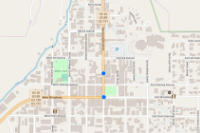

In [14]:
object_point_srvc = gis.content.search("JHWY_ML_Detection_02")[1]
object_point_srvc

In [15]:
# Convert our existing service into a pandas dataframe
object_point_lyr = object_point_srvc.layers[0]
obj_fset = object_point_lyr.query()  #querying without any conditions returns all the features
obj_df = obj_fset.df
obj_df.head()

,CreationDate,Creator,EditDate,Editor,OBJECTID,RT_Bicycle_Count,RT_Bus_Count,RT_Car_Count,RT_Motorcycle_Count,RT_Object_Count,RT_Pedestrian_Count,RT_Truck_Count,RT_Vehicle_Count,SHAPE
0,1512078543076,albe9057@esri.com_esrifederal,1512096593161,albe9057@esri.com_esrifederal,1,None,None,4,None,0,0,0,0,"{'x': -12330007.8039, 'y': 5385259.123000003}"


In [16]:
all_features = obj_fset.features
all_features

[{"geometry": {"x": -12330007.8039, "y": 5385259.123000003}, "attributes": {"OBJECTID": 1, "RT_Object_Count": 0, "RT_Vehicle_Count": 0, "RT_Car_Count": 4, "RT_Truck_Count": 0, "RT_Pedestrian_Count": 0, "RT_Bicycle_Count": null, "RT_Motorcycle_Count": null, "RT_Bus_Count": null, "CreationDate": 1512078543076, "Creator": "albe9057@esri.com_esrifederal", "EditDate": 1512096593161, "Editor": "albe9057@esri.com_esrifederal"}}]

In [17]:
from copy import deepcopy

original_feature = all_features[0]
feature_to_be_updated = deepcopy(original_feature)
feature_to_be_updated

{"geometry": {"x": -12330007.8039, "y": 5385259.123000003}, "attributes": {"OBJECTID": 1, "RT_Object_Count": 0, "RT_Vehicle_Count": 0, "RT_Car_Count": 4, "RT_Truck_Count": 0, "RT_Pedestrian_Count": 0, "RT_Bicycle_Count": null, "RT_Motorcycle_Count": null, "RT_Bus_Count": null, "CreationDate": 1512078543076, "Creator": "albe9057@esri.com_esrifederal", "EditDate": 1512096593161, "Editor": "albe9057@esri.com_esrifederal"}}

# Detection

In [18]:
logging = "verbose"  # Options: verbose | simple | cars
# logging = "simple"
# logging = "cars"

In [19]:
# Top left config
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        # Definite input and output Tensors for detection_graph
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        # Each box represents a part of the image where a particular object was detected.
        detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        # Each score represent how level of confidence for each of the objects.
        # Score is shown on the result image, together with the class label.
        detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')
        while True:
            
            # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
            image_np = np.array(ImageGrab.grab(bbox=(0,160,960,720)))
            image_np_expanded = np.expand_dims(image_np, axis=0)
            # Actual detection.
            (boxes, scores, classes, num) = sess.run(
              [detection_boxes, detection_scores, detection_classes, num_detections],
              feed_dict={image_tensor: image_np_expanded})
            
#             print(np.squeeze(classes))
            # Visualization of the results of a detection.
            vis_util.visualize_boxes_and_labels_on_image_array(
              image_np,
              np.squeeze(boxes),
              np.squeeze(classes).astype(np.int32),
              np.squeeze(scores),
              category_index,
              use_normalized_coordinates=True,
              line_thickness=8, min_score_thresh=0.5)
            
            cv2.imshow('object detection', cv2.resize(image_np, (960,560)))
            if cv2.waitKey(25) & 0xFF == ord('q'):
                cv2.destroyAllWindows()
                break
                
            car_count, people_count, bicycle_count, motorcycle_count, bus_count, truck_count = object_counter(np.squeeze(classes).astype(np.int32), np.squeeze(scores))
            vehicle_count = car_count + motorcycle_count + bus_count + truck_count
            total_count = vehicle_count + bicycle_count + people_count
            
            if logging == "verbose":
                print("/n")
                print("Detected {0} total objects...".format(str(total_count)))
                print("Detected {0} total vehicles...".format(str(vehicle_count)))
                print("Detected {0} cars...".format(str(car_count)))
                print("Detected {0} motorcycles...".format(str(motorcycle_count)))
                print("Detected {0} buses...".format(str(bus_count)))
                print("Detected {0} trucks...".format(str(truck_count)))
                print("Detected {0} pedestrians...".format(str(people_count)))
                print("Detected {0} bicycles...".format(str(bicycle_count)))
            
            elif logging == "simple":
                print("/n")
                print("Detected {0} total objects...".format(str(total_count)))
                print("Detected {0} total vehicles...".format(str(vehicle_count)))
                print("Detected {0} pedestrians...".format(str(people_count)))
                print("Detected {0} bicycles...".format(str(bicycle_count)))
                
            elif logging == "cars":
                print("/n")
                print("Detected {0} cars...".format(str(car_count)))
            
            features_for_update = []
            feature_to_be_updated.attributes['RT_Object_Count'] = total_count
            feature_to_be_updated.attributes['RT_Vehicle_Count'] = vehicle_count
            feature_to_be_updated.attributes['RT_Car_Count'] = car_count
            feature_to_be_updated.attributes['RT_Bus_Count'] = bus_count
            feature_to_be_updated.attributes['RT_Truck_Count'] = truck_count
            feature_to_be_updated.attributes['RT_Motorcycle_Count'] = motorcycle_count
            feature_to_be_updated.attributes['RT_Pedestrian_Count'] = people_count
            feature_to_be_updated.attributes['RT_Bicycle_Count'] = bicycle_count
            
#             feature_to_be_updated.attributes['rt_car_count'] = car_count
            features_for_update.append(feature_to_be_updated)
            object_point_lyr.edit_features(updates=features_for_update)                

/n
Detected 0 total objects...
Detected 0 total vehicles...
Detected 0 cars...
Detected 0 motorcycles...
Detected 0 buses...
Detected 0 trucks...
Detected 0 pedestrians...
Detected 0 bicycles...
/n
Detected 0 total objects...
Detected 0 total vehicles...
Detected 0 cars...
Detected 0 motorcycles...
Detected 0 buses...
Detected 0 trucks...
Detected 0 pedestrians...
Detected 0 bicycles...
/n
Detected 0 total objects...
Detected 0 total vehicles...
Detected 0 cars...
Detected 0 motorcycles...
Detected 0 buses...
Detected 0 trucks...
Detected 0 pedestrians...
Detected 0 bicycles...
/n
Detected 0 total objects...
Detected 0 total vehicles...
Detected 0 cars...
Detected 0 motorcycles...
Detected 0 buses...
Detected 0 trucks...
Detected 0 pedestrians...
Detected 0 bicycles...
/n
Detected 0 total objects...
Detected 0 total vehicles...
Detected 0 cars...
Detected 0 motorcycles...
Detected 0 buses...
Detected 0 trucks...
Detected 0 pedestrians...
Detected 0 bicycles...
/n
Detected 0 total objec

/n
Detected 1 total objects...
Detected 1 total vehicles...
Detected 1 cars...
Detected 0 motorcycles...
Detected 0 buses...
Detected 0 trucks...
Detected 0 pedestrians...
Detected 0 bicycles...
/n
Detected 1 total objects...
Detected 1 total vehicles...
Detected 1 cars...
Detected 0 motorcycles...
Detected 0 buses...
Detected 0 trucks...
Detected 0 pedestrians...
Detected 0 bicycles...
/n
Detected 2 total objects...
Detected 2 total vehicles...
Detected 2 cars...
Detected 0 motorcycles...
Detected 0 buses...
Detected 0 trucks...
Detected 0 pedestrians...
Detected 0 bicycles...
/n
Detected 2 total objects...
Detected 2 total vehicles...
Detected 2 cars...
Detected 0 motorcycles...
Detected 0 buses...
Detected 0 trucks...
Detected 0 pedestrians...
Detected 0 bicycles...
/n
Detected 2 total objects...
Detected 2 total vehicles...
Detected 2 cars...
Detected 0 motorcycles...
Detected 0 buses...
Detected 0 trucks...
Detected 0 pedestrians...
Detected 0 bicycles...
/n
Detected 1 total objec

/n
Detected 0 total objects...
Detected 0 total vehicles...
Detected 0 cars...
Detected 0 motorcycles...
Detected 0 buses...
Detected 0 trucks...
Detected 0 pedestrians...
Detected 0 bicycles...
/n
Detected 0 total objects...
Detected 0 total vehicles...
Detected 0 cars...
Detected 0 motorcycles...
Detected 0 buses...
Detected 0 trucks...
Detected 0 pedestrians...
Detected 0 bicycles...
/n
Detected 0 total objects...
Detected 0 total vehicles...
Detected 0 cars...
Detected 0 motorcycles...
Detected 0 buses...
Detected 0 trucks...
Detected 0 pedestrians...
Detected 0 bicycles...
/n
Detected 0 total objects...
Detected 0 total vehicles...
Detected 0 cars...
Detected 0 motorcycles...
Detected 0 buses...
Detected 0 trucks...
Detected 0 pedestrians...
Detected 0 bicycles...
/n
Detected 0 total objects...
Detected 0 total vehicles...
Detected 0 cars...
Detected 0 motorcycles...
Detected 0 buses...
Detected 0 trucks...
Detected 0 pedestrians...
Detected 0 bicycles...
/n
Detected 0 total objec

/n
Detected 10 total objects...
Detected 10 total vehicles...
Detected 10 cars...
Detected 0 motorcycles...
Detected 0 buses...
Detected 0 trucks...
Detected 0 pedestrians...
Detected 0 bicycles...
/n
Detected 9 total objects...
Detected 9 total vehicles...
Detected 9 cars...
Detected 0 motorcycles...
Detected 0 buses...
Detected 0 trucks...
Detected 0 pedestrians...
Detected 0 bicycles...
/n
Detected 9 total objects...
Detected 9 total vehicles...
Detected 9 cars...
Detected 0 motorcycles...
Detected 0 buses...
Detected 0 trucks...
Detected 0 pedestrians...
Detected 0 bicycles...
/n
Detected 7 total objects...
Detected 7 total vehicles...
Detected 7 cars...
Detected 0 motorcycles...
Detected 0 buses...
Detected 0 trucks...
Detected 0 pedestrians...
Detected 0 bicycles...
/n
Detected 9 total objects...
Detected 8 total vehicles...
Detected 8 cars...
Detected 0 motorcycles...
Detected 0 buses...
Detected 0 trucks...
Detected 1 pedestrians...
Detected 0 bicycles...
/n
Detected 9 total ob

/n
Detected 4 total objects...
Detected 4 total vehicles...
Detected 4 cars...
Detected 0 motorcycles...
Detected 0 buses...
Detected 0 trucks...
Detected 0 pedestrians...
Detected 0 bicycles...
/n
Detected 4 total objects...
Detected 3 total vehicles...
Detected 3 cars...
Detected 0 motorcycles...
Detected 0 buses...
Detected 0 trucks...
Detected 1 pedestrians...
Detected 0 bicycles...
/n
Detected 5 total objects...
Detected 4 total vehicles...
Detected 4 cars...
Detected 0 motorcycles...
Detected 0 buses...
Detected 0 trucks...
Detected 1 pedestrians...
Detected 0 bicycles...
/n
Detected 5 total objects...
Detected 4 total vehicles...
Detected 4 cars...
Detected 0 motorcycles...
Detected 0 buses...
Detected 0 trucks...
Detected 1 pedestrians...
Detected 0 bicycles...
/n
Detected 5 total objects...
Detected 4 total vehicles...
Detected 4 cars...
Detected 0 motorcycles...
Detected 0 buses...
Detected 0 trucks...
Detected 1 pedestrians...
Detected 0 bicycles...
/n
Detected 5 total objec

/n
Detected 2 total objects...
Detected 2 total vehicles...
Detected 0 cars...
Detected 0 motorcycles...
Detected 1 buses...
Detected 1 trucks...
Detected 0 pedestrians...
Detected 0 bicycles...
/n
Detected 2 total objects...
Detected 2 total vehicles...
Detected 0 cars...
Detected 0 motorcycles...
Detected 1 buses...
Detected 1 trucks...
Detected 0 pedestrians...
Detected 0 bicycles...
/n
Detected 2 total objects...
Detected 2 total vehicles...
Detected 0 cars...
Detected 0 motorcycles...
Detected 1 buses...
Detected 1 trucks...
Detected 0 pedestrians...
Detected 0 bicycles...
/n
Detected 2 total objects...
Detected 2 total vehicles...
Detected 0 cars...
Detected 0 motorcycles...
Detected 1 buses...
Detected 1 trucks...
Detected 0 pedestrians...
Detected 0 bicycles...
/n
Detected 2 total objects...
Detected 2 total vehicles...
Detected 0 cars...
Detected 0 motorcycles...
Detected 1 buses...
Detected 1 trucks...
Detected 0 pedestrians...
Detected 0 bicycles...
/n
Detected 2 total objec

In [ ]:
# Top left config
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        # Definite input and output Tensors for detection_graph
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        # Each box represents a part of the image where a particular object was detected.
        detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        # Each score represent how level of confidence for each of the objects.
        # Score is shown on the result image, together with the class label.
        detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')
        while True:
            
            # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
            image_np = np.array(ImageGrab.grab(bbox=(0,160,960,720)))
            image_np_expanded = np.expand_dims(image_np, axis=0)
            # Actual detection.
            (boxes, scores, classes, num) = sess.run(
              [detection_boxes, detection_scores, detection_classes, num_detections],
              feed_dict={image_tensor: image_np_expanded})
            
#             print(np.squeeze(classes))
            # Visualization of the results of a detection.
            vis_util.visualize_boxes_and_labels_on_image_array(
              image_np,
              np.squeeze(boxes),
              np.squeeze(classes).astype(np.int32),
              np.squeeze(scores),
              category_index,
              use_normalized_coordinates=True,
              line_thickness=8, min_score_thresh=0.5)
            
            cv2.imshow('object detection', cv2.resize(image_np, (960,560)))
            if cv2.waitKey(25) & 0xFF == ord('q'):
                cv2.destroyAllWindows()
                break
                
            car_count = car_counter(np.squeeze(classes).astype(np.int32), np.squeeze(scores))
            print("Detected {0} cars...".format(str(car_count)))
            
            features_for_update = []
            feature_to_be_updated.attributes['RT_Car_Count'] = car_count
#             feature_to_be_updated.attributes['rt_car_count'] = car_count
            features_for_update.append(feature_to_be_updated)
            object_point_lyr.edit_features(updates=features_for_update)                